In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam

In [4]:
# Loading the dataset from the 'train' directory

batch_size = 512
seed = 1337 # Keep the seed same for both 'train' & 'validation' to avoid overlap

train_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train", 
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=seed)

val_ds = keras.preprocessing.text_dataset_from_directory(
    "../input/positionalembedding/hw2-ycbs-273-intro-to-prac-ml (1)/train",
    batch_size=batch_size,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=seed)

text_only_train_ds = train_ds.map(lambda x, y: x)

Found 120000 files belonging to 4 classes.
Using 96000 files for training.
Found 120000 files belonging to 4 classes.
Using 24000 files for validation.


In [5]:
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_length = 600
max_tokens = 20000
text_vectorization = layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y))
int_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y))
# int_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y))

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [7]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [8]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [9]:
#setting compile and learning rate
adam = Adam(lr = 3e-4)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
positional_embedding (Positi (None, None, 256)         5273600   
_________________________________________________________________
transformer_encoder (Transfo (None, None, 256)         543776    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 5,818,404
Trainable params: 5,818,404
Non-trainable params: 0
___________________________________________________

In [10]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience = 5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="full_transformer_encoder.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [11]:
model_history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks_list)
model = keras.models.load_model(
    "full_transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_val_ds)[1]:.3f}")

Epoch 1/10
188/188 [==============================] - 342s 2s/step - loss: 1.4655 - accuracy: 0.5725 - val_loss: 0.2627 - val_accuracy: 0.9112
Epoch 2/10
188/188 [==============================] - 295s 2s/step - loss: 0.2236 - accuracy: 0.9237 - val_loss: 0.2650 - val_accuracy: 0.9105
Epoch 3/10
188/188 [==============================] - 299s 2s/step - loss: 0.1503 - accuracy: 0.9477 - val_loss: 0.3047 - val_accuracy: 0.9048
Epoch 4/10
188/188 [==============================] - 317s 2s/step - loss: 0.1173 - accuracy: 0.9589 - val_loss: 0.3578 - val_accuracy: 0.9021
Epoch 5/10
188/188 [==============================] - 293s 2s/step - loss: 0.0923 - accuracy: 0.9656 - val_loss: 0.4120 - val_accuracy: 0.9013
Epoch 6/10
47/47 [==============================] - 23s 448ms/step - loss: 0.2627 - accuracy: 0.9112
Test acc: 0.911


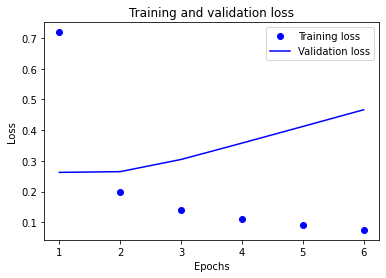

In [20]:
import matplotlib.pyplot as plt
#draw plot for visualization
history_dict = model_history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.show()

In [21]:
# Using the trained model to make prediction on unseen (test) data
# Here we use the 'adapted' text_vectorization layer and include it as part of a prediction_model

prediction_model = tf.keras.Sequential(
    [text_vectorization, model])

prediction_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])

# Test it with `val_ds`, which yields raw strings
loss, accuracy = prediction_model.evaluate(val_ds)
print("Accuracy: {:2.2%}".format(accuracy))

47/47 [==============================] - 42s 766ms/step - loss: 0.2584 - accuracy: 0.9107
Accuracy: 91.12%


In [22]:
# Read the test data in the form of a dataframe

df_test_data = pd.read_csv('../input/positionalembedding/data_test_df.csv')
inputs = df_test_data['data']

In [23]:
# Make sure you use the 'prediction_model' and not the trained 'model' alone
# If you use the 'model' object, you will run int error as the data is still in the 'text' format and needs vectorization

predicted_scores = prediction_model.predict(inputs)
predicted_scores[0:5]

array([[1.15281805e-01, 3.21140484e-04, 8.63366663e-01, 2.10303627e-02],
       [2.22659088e-03, 1.75290729e-03, 5.08685410e-03, 9.90933657e-01],
       [4.43949737e-03, 1.92718406e-03, 3.15297171e-02, 9.62103665e-01],
       [3.44604328e-02, 4.84262072e-02, 8.67101476e-02, 8.30403209e-01],
       [9.04693734e-03, 5.18387067e-04, 1.58412158e-02, 9.74593401e-01]],
      dtype=float32)

In [24]:
# populating the dataframe to make a submission on Kaggle

df_predictions = pd.DataFrame(predicted_scores, columns=['solution_' + str(i+1) for i in range(4)])
df_predictions.index.rename('Id', inplace=True)

df_predictions.head(30)

,solution_1,solution_2,solution_3,solution_4
Id,,,,
0,0.115282,0.000321,0.863367,0.021030
1,0.002227,0.001753,0.005087,0.990934
2,0.004439,0.001927,0.031530,0.962104
3,0.034460,0.048426,0.086710,0.830403
4,0.009047,0.000518,0.015841,0.974593
5,0.003555,0.002754,0.018341,0.975350
6,0.003074,0.000238,0.002631,0.994057
7,0.002165,0.001992,0.007831,0.988012
8,0.017135,0.000135,0.019497,0.963233


In [25]:
# If using colab, then download this and submit on Kaggle

df_predictions.to_csv('df_predictions_6.csv')